<a href="https://colab.research.google.com/github/MandbeZ/TFM_sequia/blob/main/notebooks/4_2_Modelo_Univariante_Redes_Neuronales__SPI_SPEI(Cluster).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install sktime
%pip install tensorflow==2.1
%pip install keras-tcn
%pip install numpy==1.19.2
%matplotlib inline

In [ ]:
from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)
simplefilter(action="ignore", category=FutureWarning)

## Importar librerías básicas

In [ ]:
import numpy as np
import pandas as pd
import datetime
import random
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Importar librerías de Tensor Flow y Keras

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, Input, GRU
from tensorflow.keras import backend as K
from tcn import TCN
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error

from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)

## Definición de Funciones

In [ ]:
#Colores para los plot
colores = plt.get_cmap('Set1', 30)

def cargar_datos(archivo, lista_cluster, c):
    data = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/' + archivo,  sep = ',', parse_dates=True)
    estaciones = lista_cluster[lista_cluster['cluster'] == c]
    nom_cols = [col for est in estaciones['id'] for col in data.columns if str(est) in col]
    nom_cols.append('fecha')
    datos = data[nom_cols]
    return datos

'''Llevar la  fecha a índice, configurar como periodo'''
def procesa_datos(data):
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.dropna()
    data = data.set_index('fecha')
    data.index = data.index.to_period('M')
    return data

'''Se normalizan los datos Min-Max: [0,1]'''
def normalizar_datos(data,param):
    return (data - param['min']) / ( param['max'] - param['min'])

'''Dividir el Dataset en Entrenamiento y prueba'''
def dividir_datos(serie, tamanio):
    y_train, y_test = temporal_train_test_split(serie, test_size=tamanio)
    return y_train, y_test

def plotear(x, y, y_pred=None):
  fig, ax = plt.subplots(1,1, figsize=(15,5))
  ax.plot(x, 'o-',  c=colores(1), markersize=3.5, label='Entrenamiento(Train)')
  ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y, 'x-', c=colores(5), markersize=3.5, label='Validación(Test)')
  if y_pred is not None:
    ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y_pred, 'o-', c=colores(8), markersize=3.5, label='Predicción(Pred)')
  ax.legend()

def evaluar(test,pred):
  mape = mean_absolute_percentage_error(test, pred, symmetric=False)
  mae = mean_absolute_error(test, pred) 
  rmse = mean_squared_error(test, pred, square_root=True) # square_root=True RMSE , false MSE)
  mse = mean_squared_error(test, pred, square_root=False) # square_root=True RMSE , false MSE)
  return [mae, mape, rmse, mse]

# 1. Cargar los datos de SPI o SPEI

In [ ]:
'''Cargar archivo con los clusters'''
cluster = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/cluster_4.csv',  sep = ',', usecols = {'id', 'cluster'})

'''Cargar archivo y extraer un cluster'''
datos = cargar_datos('indices_spi3.csv', cluster,3)


datos_p = procesa_datos(datos)
'''Diferenciar las series'''
datos_p_d = datos_p.diff()
datos_p=datos_p_d.dropna()

# 2. Definir horizonte de predicción y dividir el dataset

In [ ]:
'''Definir el horizonte de la prediccion'''
tam_ypred = 12
'''División del DataSet en Entramiento y test'''
train = datos_p.iloc[:-tam_ypred]
test = datos_p.iloc[-tam_ypred:]

# 3. Normalizar los datos de entrenamiento

In [ ]:
s_train = []
for i in list(train):
    s_train.append(train[i].tolist())

s_test = []
for i in list(test):
    s_test.append(test[i].tolist())

s_train = np.asarray(s_train)
s_test = np.asarray(s_test)


In [ ]:
train_norm = []
#Obtener los parámetros de normalización de train
lista_param = []

for s in s_train:
  params = {}
  params['max'] = s.max()
  params['min'] = s.min()
  lista_param.append(params)
  norm = normalizar_datos(s, params)
  train_norm.append(norm)

In [ ]:
# Aplicar los parámetros de normalización al test 
test_norm = []
for x, s in enumerate(s_test):
  params = lista_param[x]
  norm = normalizar_datos(s,params)
  test_norm.append(norm)
test_norm[len(test_norm)-1]

array([0.27835274, 0.60608021, 0.52932298, 0.60866753, 0.43078913,
       0.46679603, 0.74665804, 0.3792583 , 0.49590341, 0.44200086,
       0.41116861, 0.63863734])

# 4. Definir tamaño de ventana (pasado histórico)  y horizonte de predicción

In [ ]:
ventana = 240  #Pasado histórico
hpred = 12  #Horizonte de Predicción 

# 5. Estategia de Ventana Móvil

In [ ]:


x_train, y_train = [], []
x_test, y_test = [], []

for i, ts in enumerate(train_norm):
  # Train data
  ts_x_train, ts_y_train = [], []
  for j in range(0, ts.shape[0] - hpred + 1):
      indices = range(j - ventana, j, 1)
      
      ts_x_train.append(np.reshape(ts[indices], (ventana, 1)))
      ts_y_train.append(ts[j:j + hpred])
  x_train.extend(np.asarray(ts_x_train))
  y_train.extend(np.asarray(ts_y_train))
  # Test data
  ts_x_test = np.reshape(np.asarray(ts[-ventana:]), (ventana, 1))
  ts_y_test=  test_norm[i]
  x_test.extend(np.asarray([ts_x_test]))
  y_test.extend(np.asarray([ts_y_test]))
  

x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test, dtype='float32')

print("DATOS DE ENTRENAMIENTO")
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("DATOS DE VALIDACIÓN")
print("x_test", x_test.shape)
print("y_test", y_test.shape)

DATOS DE ENTRENAMIENTO
x_train (3178, 240, 1)
y_train (3178, 12)

DATOS DE VALIDACIÓN
x_test (7, 240, 1)
y_test (7, 12)


In [ ]:
# from collections import defaultdict
# resultados = defaultdict(lambda: {})

# Definir DF de evaluacio y prediccion
eval = pd.DataFrame(index=['MAE','MAPE' ,'RMSE','MSE'])
pred = pd.DataFrame()

In [ ]:
#Definición de Hiperparámetros para modelo de Perceptrón multicapa
error='mae'
tbatch=128
epocas=135
# Fijar la semilla para los experimentos
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

# Perceptrón Multicapa MLP (Multi-Layer Perceptron)

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 240, 1)]          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 16)                3856      
_________________________________________________________________
dense_99 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_100 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_101 (Dense)            (None, 12)                396       
Total params: 5,852
Trainable params: 5,852
Non-trainable params: 0
________________________________________________________

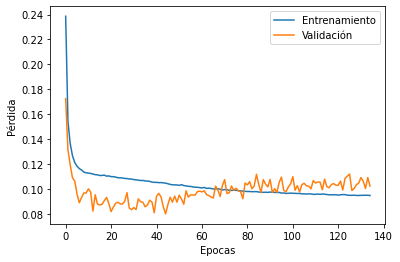

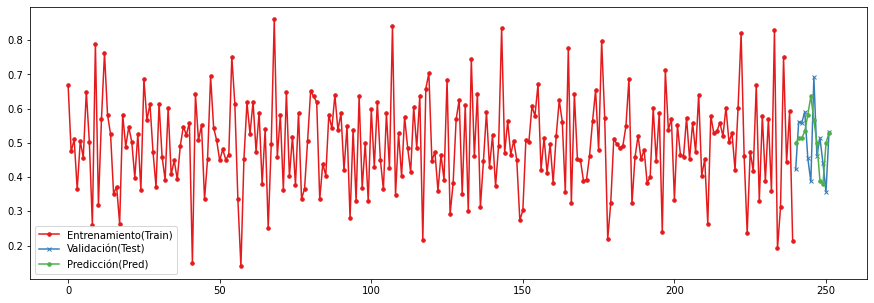

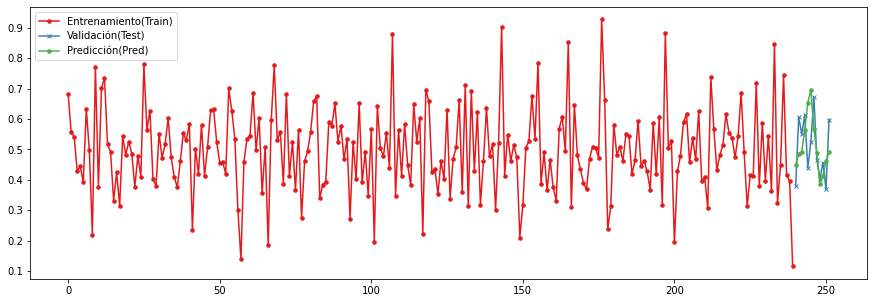

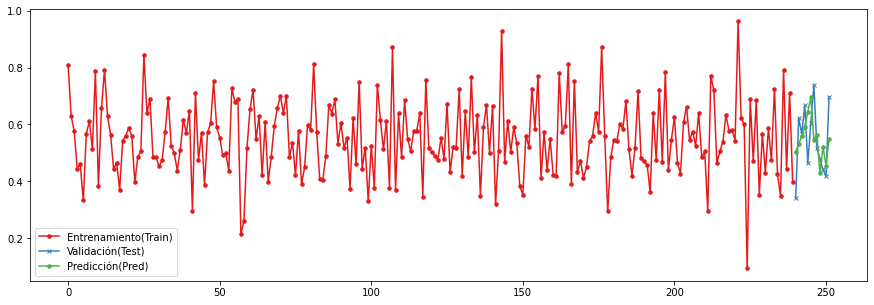

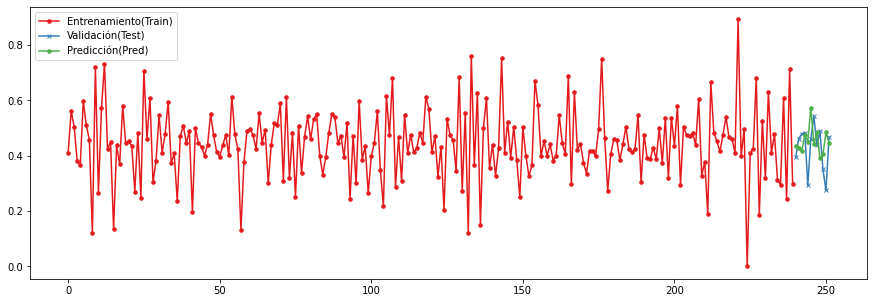

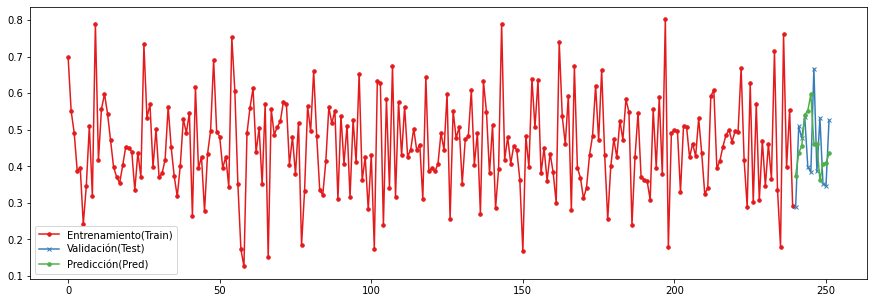

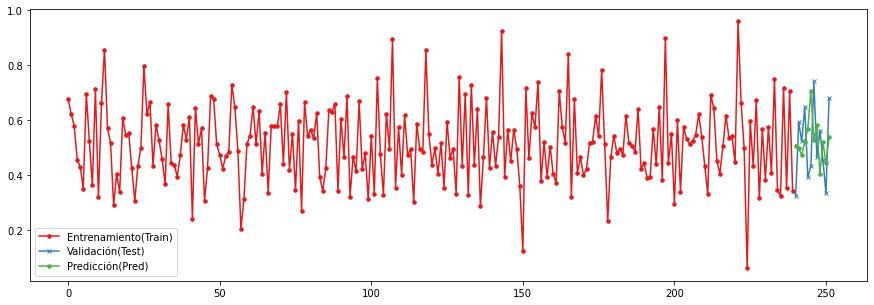

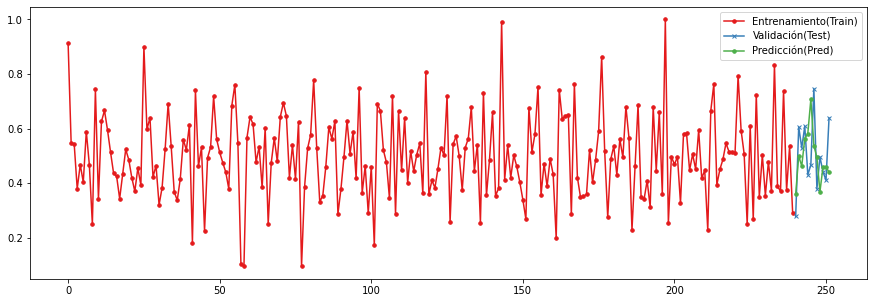

In [ ]:
inp = Input(shape=x_train.shape[-2:])
x = Flatten()(inp)
x = Dense(16)(x)
x = Dense(32)(x)
x = Dense(32)(x)
x = Dense(hpred)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss=error)
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=tbatch,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))
# Graficas de entrenamiento y validación
plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])

predicciones = model.predict(x_test)
# mae = mean_absolute_error(y_test, predicciones)
# resultados['MAE']['MLP'] = mae
# resultados['Y_PRED']['MLP'] = predicciones
# print(pd.DataFrame(resultados)['MAE'])
# Evaluar MLP
eval['MLP']=evaluar(y_test,predicciones)
mlt = pd.DataFrame(predicciones, index=['mlt'+datos_p.columns.astype(str)]).T
pred=pd.concat([pred,mlt],axis=1)

for x, y, y_pred in zip(x_test, y_test, predicciones):
  plotear(x,y,y_pred)

# Red Recurrente LSTM con varias capas

In [ ]:
#Definición de Hiperparámetros para modelo de LSTM
error='mae'
tbatch=128
epocas=100
# Fijar la semilla para los experimentos
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 240, 1)]          0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 240, 64)           16896     
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_102 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_103 (Dense)            (None, 12)                780       
Total params: 32,204
Trainable params: 32,204
Non-trainable params: 0
_________________________________________________________________
None
Train on 3178 samples, validate on 7 samples
Epoch 1/100
3178/3178 [==============================] - 3s 851us/samp

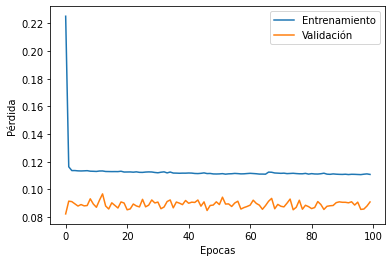

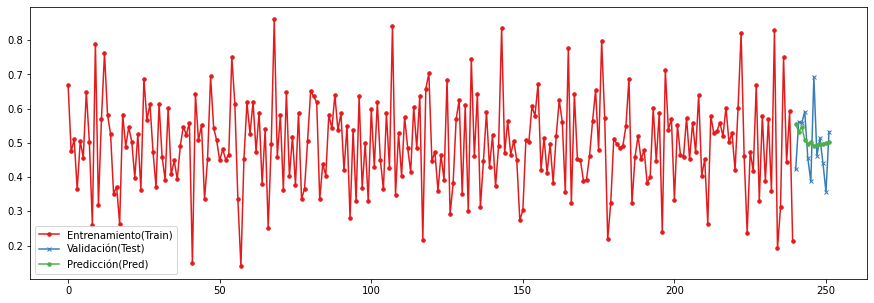

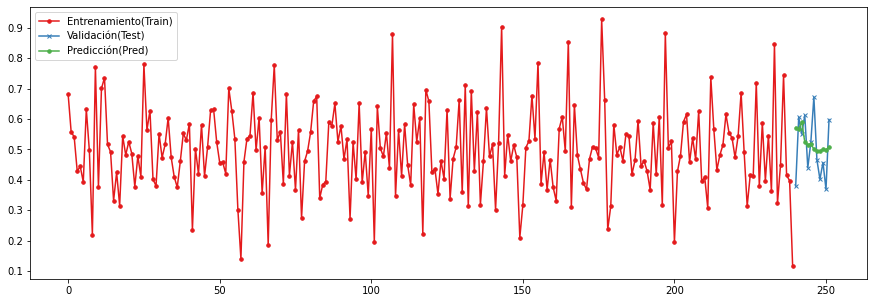

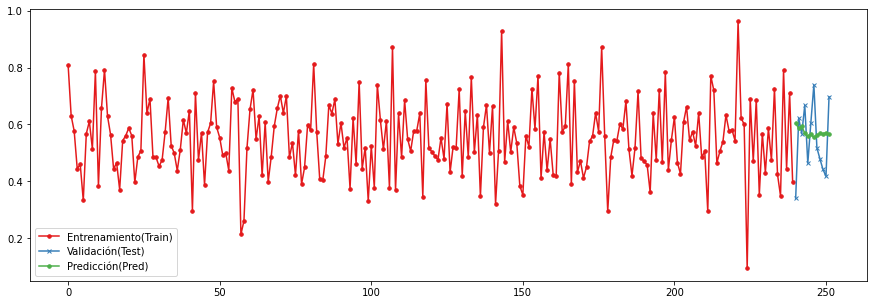

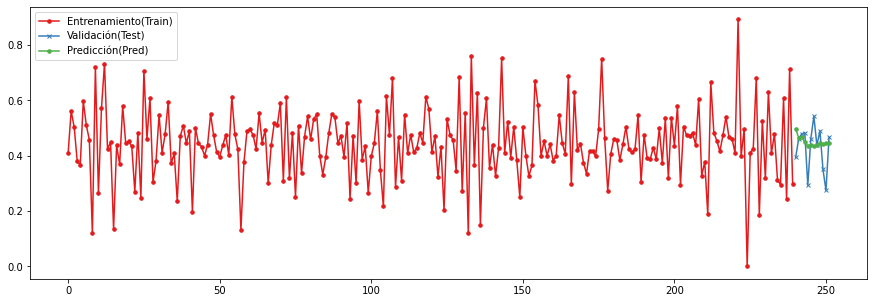

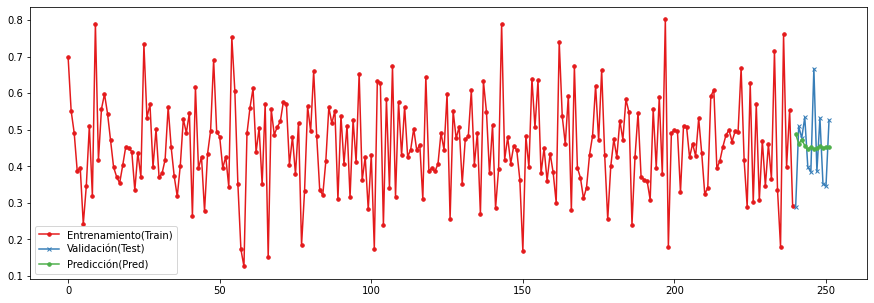

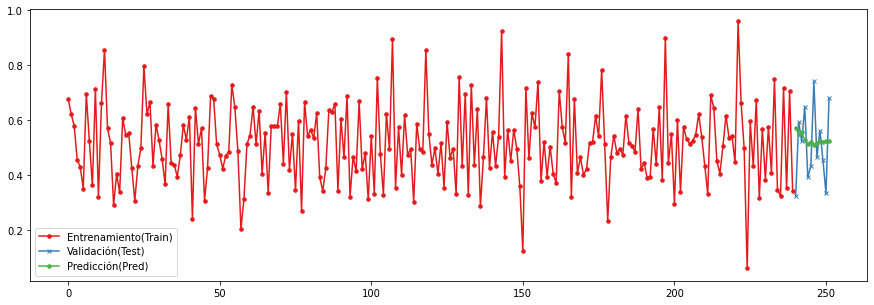

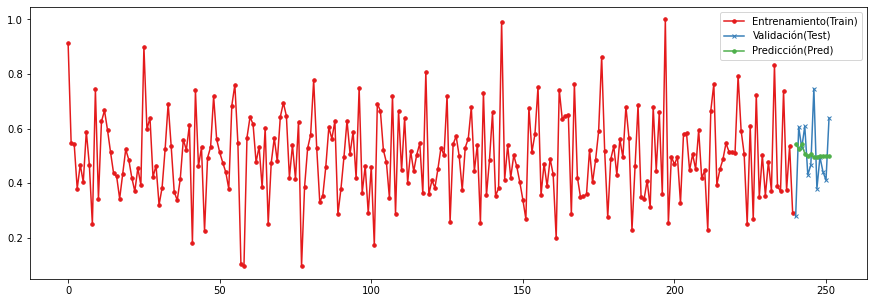

In [ ]:
#Varias capas LSTM, una sobre otra. 
inp = Input(shape=x_train.shape[-2:])
x = LSTM(64, return_sequences=True)(inp)
x = LSTM(32, return_sequences=False)(x)
x = Dense(64)(x)
x = Dense(hpred)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss=error)
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=tbatch,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))

# Graficas de entrenamiento y validación
plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])

predicciones = model.predict(x_test)
# mae = mean_absolute_error(y_test, predicciones)
# resultados['MAE']['LSTM'] = mae
# resultados['Y_PRED']['LSTM'] = predicciones
# print(pd.DataFrame(resultados)['MAE'])
# Evaluar LSTM
eval['LSTM']=evaluar(y_test,predicciones)
lstm = pd.DataFrame(predicciones, index=['lstm'+datos_p.columns.astype(str)]).T
pred=pd.concat([pred,lstm],axis=1)

for x, y, y_pred in zip(x_test, y_test, predicciones):
  plotear(x,y,y_pred)

#  Red Convolucional TCN(Temporal Convolutional Network)

In [ ]:
#Definición de Hiperparámetros para modelo de TCN
error='mae'
tbatch=128
epocas=100
# Fijar la semilla para los experimentos
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 240, 1)]          0         
_________________________________________________________________
tcn_14 (TCN)                 (None, 64)                160960    
_________________________________________________________________
dense_104 (Dense)            (None, 12)                780       
Total params: 161,740
Trainable params: 161,740
Non-trainable params: 0
_________________________________________________________________
None
Train on 3178 samples, validate on 7 samples
Epoch 1/100
3178/3178 [==============================] - 3s 856us/sample - loss: 1.4595 - val_loss: 0.3361
Epoch 2/100
3178/3178 [==============================] - 1s 319us/sample - loss: 0.2747 - val_loss: 0.2179
Epoch 3/100
3178/3178 [==============================] - 1s 305us/sample - loss: 0.1957 - val_loss: 0.1830
Epoch 4/100

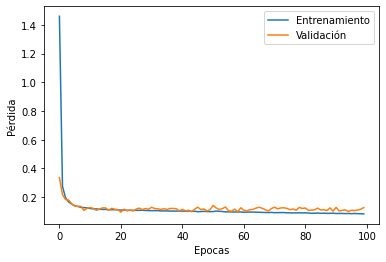

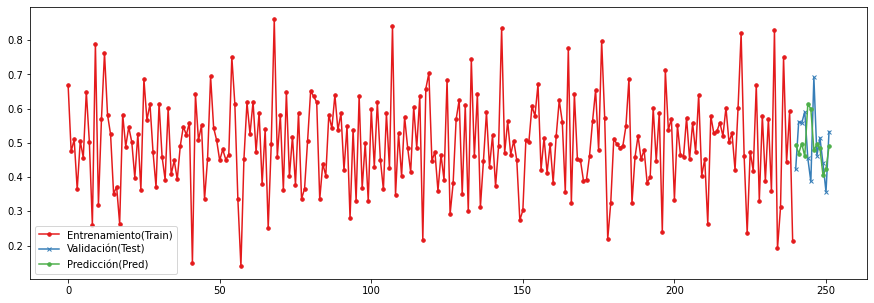

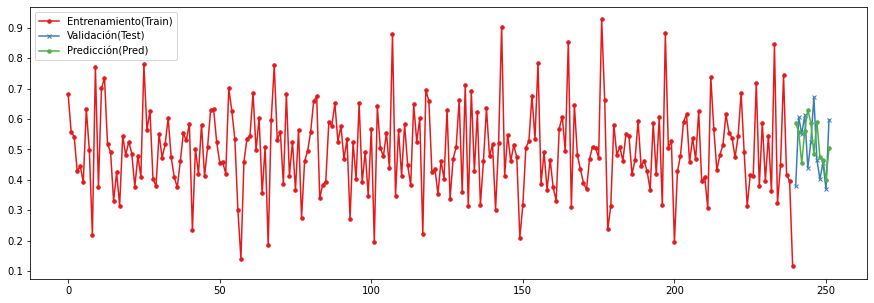

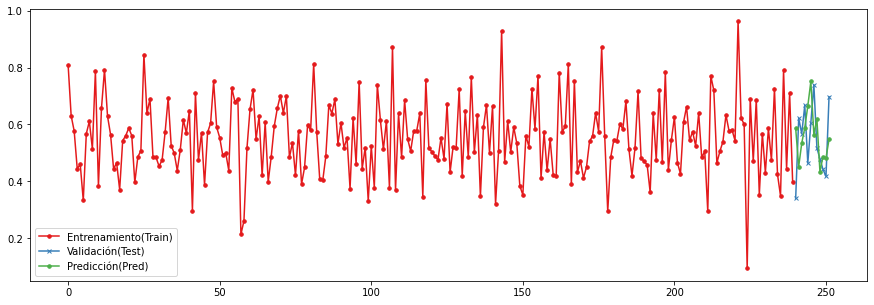

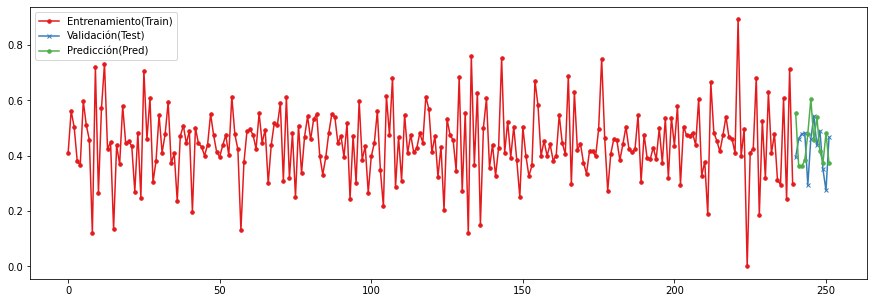

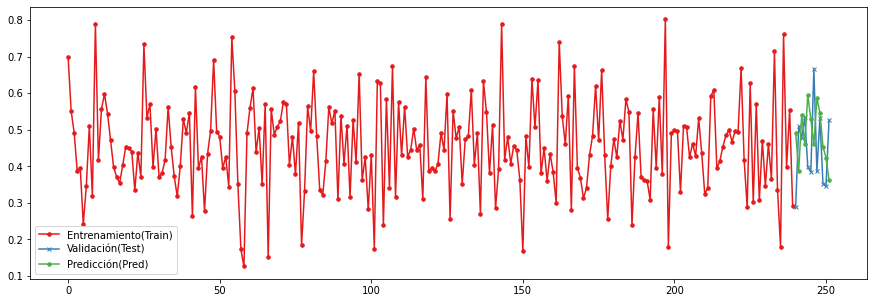

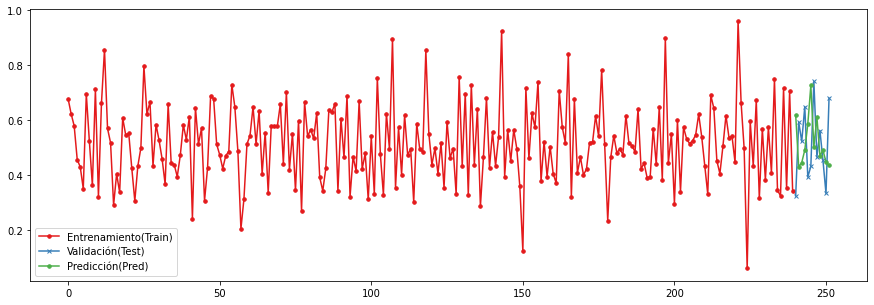

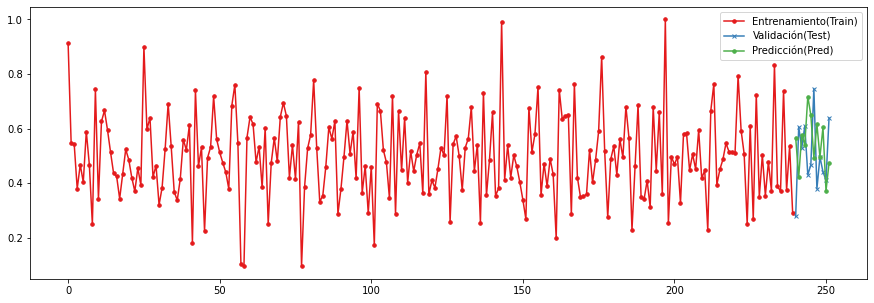

In [ ]:
tbatch=128
epocas=100

inp = Input(shape=x_train.shape[-2:])
x = TCN(nb_filters=64, kernel_size=3, nb_stacks=1, dilations=[1,2,4,8,16,32,64])(inp)
x = Dense(hpred)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss=error)
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=tbatch,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))

# Graficas de entrenamiento y validación
plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])

predicciones = model.predict(x_test)
# mae = mean_absolute_error(y_test, predicciones)
# resultados['MAE']['TCN'] = mae
# resultados['Y_PRED']['TCN'] = predicciones
# print(pd.DataFrame(resultados)['MAE'])

# Evaluar TCN
eval['TCN']=evaluar(y_test,predicciones)
tcn = pd.DataFrame(predicciones, index=['tcn'+datos_p.columns.astype(str)]).T
pred=pd.concat([pred,tcn],axis=1)

for x, y, y_pred in zip(x_test, y_test, predicciones):
 plotear(x,y,y_pred)

In [ ]:
eval

,MLP,LSTM,TCN
MAE,0.102384,0.090902,0.127427
MAPE,0.220866,0.204368,0.280570
RMSE,0.111610,0.097854,0.137809
MSE,0.014666,0.012700,0.021878


In [ ]:
pred

,mlt106,mlt121,mlt200,mlt201,mlt202,mlt203,mlt204,lstm106,lstm121,lstm200,lstm201,lstm202,lstm203,lstm204,tcn106,tcn121,tcn200,tcn201,tcn202,tcn203,tcn204
0,0.499115,0.448453,0.503135,0.436148,0.374449,0.507696,0.359408,0.553645,0.571811,0.604473,0.498036,0.488199,0.573111,0.541814,0.495022,0.587438,0.586190,0.553633,0.490890,0.619669,0.567009
1,0.513268,0.486024,0.530969,0.426294,0.437453,0.496883,0.499728,0.533093,0.566415,0.585893,0.463904,0.462095,0.547975,0.525663,0.468813,0.556668,0.452055,0.361171,0.386977,0.429488,0.421461
2,0.514297,0.492304,0.559240,0.415869,0.454453,0.473584,0.462625,0.546806,0.591081,0.593937,0.466409,0.473017,0.555479,0.542252,0.498061,0.454599,0.534245,0.361220,0.541819,0.445822,0.577721
3,0.533174,0.564574,0.592505,0.476468,0.540374,0.520617,0.563403,0.508866,0.524317,0.568768,0.448325,0.456613,0.527182,0.508296,0.460276,0.559970,0.588407,0.383473,0.461908,0.491084,0.540929
4,0.582676,0.653779,0.644220,0.451136,0.552571,0.568992,0.581554,0.497700,0.515638,0.557898,0.435249,0.447083,0.514516,0.499792,0.613995,0.630481,0.665173,0.478833,0.595528,0.585892,0.717415
5,0.635554,0.695714,0.696659,0.572878,0.597458,0.706856,0.707144,0.503328,0.517618,0.565515,0.439555,0.452941,0.521659,0.505784,0.599088,0.586997,0.751602,0.605122,0.528919,0.726481,0.649128
6,0.566792,0.567914,0.546257,0.442382,0.462156,0.527138,0.537337,0.491872,0.501131,0.554281,0.434147,0.446881,0.511313,0.494669,0.478452,0.486391,0.564577,0.456464,0.460926,0.502375,0.493403
7,0.499761,0.486959,0.562064,0.484039,0.459785,0.583124,0.494549,0.493237,0.495639,0.562134,0.438089,0.449081,0.516625,0.495791,0.495328,0.589743,0.618944,0.538922,0.587077,0.611099,0.616433
8,0.389542,0.385869,0.428877,0.391730,0.361524,0.403562,0.368361,0.497529,0.495134,0.568727,0.445011,0.455727,0.522897,0.499764,0.485302,0.474281,0.433493,0.416480,0.546285,0.470926,0.495619
9,0.380271,0.412892,0.521290,0.405227,0.407690,0.519035,0.458784,0.497410,0.499675,0.567447,0.441211,0.450983,0.521908,0.498806,0.405478,0.464433,0.487029,0.374349,0.453704,0.490427,0.604471
